# Data Cleaning and Feature Engineering

In this notebook we will perform all of the data cleaning and feature engineering that is as a precondition for running our regressions. Our output will be a dataset that is ready for regression analysis.

### I. Import Libraries, Packages, and Data

In [32]:
#brew install libomp
#pip install xgboost
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from matplotlib.pylab import rcParams
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
# Import data

#Import training data
train_data_url = 'https://raw.githubusercontent.com/cal-dortiz/W207_Applied-_Machine_Learning/main/Final_Project/Data/train.csv'
df_train = pd.read_csv(train_data_url)

#Import testing data
test_data_url = 'https://raw.githubusercontent.com/cal-dortiz/W207_Applied-_Machine_Learning/main/Final_Project/Data/test.csv'
df_test = pd.read_csv(test_data_url)


In [9]:
#Display the training data set to ensure it was properly loaded
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [10]:
#View shape of dataset
df_train.shape

(1460, 81)

There are 81 columns in the training data set. While not shown, the test data includes 80 columns - and omits one critical column, SalePrice. We do not use the testing data in this analysis as without SalePrice it is impossible for us to determine how accurate our model can predict the housing prices assocaited with that data. We will instead use our training data, and split this into training and test data, which we will do later.

Other attributes of the data that are apparent is that each row corresponds to a single house and its various features. We next proceed to clean the data and determine what data may be missing and what modifications need to be made before we can begin our analysis. 

### II. General Data Checking and Cleaning

In [11]:
#Check to ensure there are no duplicate IDs/double-counted data
print('Duplicate IDs: {}'.format(df_train.duplicated('Id').sum()))

Duplicate IDs: 0


### II.A. Data Removal

Based on the exploritory data analysis in the prior file, we drop several attributes that have no identificbly useful relationship with sales price. This includes ID, MiscFeatures, as well as Pool Quality, Alley, Fence, and Total Basement Square Footage. We also remove rows that are missing a data when such instances appear unique.

In [6]:
# Remove columns without any identifiably useful relationship with sales price - ID and MiscFeatures.
df_train = df_train.drop(columns=['Id', 'MiscFeature','PoolQC','Alley','Fence','TotalBsmtSF'])

# Drop the row with the missing electrical data
df_train = df_train.dropna( how='any', subset=['Electrical'])

### II.B. New Category for Total SqFt

Our prior EDA confirms that larger houses (in terms of overall square footage) are highly correlated with sale prices. We seek to take several steps to consolidate this relationsihp and avoid potential multicollinearity among different variables. 

The basement area is generally not used in assessing property value, and is likely to be highly correlated with the size of the first floor of the house. Meanwhile,  the square footage of the remainder of the house is generally very useful in appraising a house's value. As a result, we have previusly dropped the variable 'TotalBsmtSF' and create a new variable that calculates the square footage of the first and second floors into a single variable. 

Note that we will leave the basement data seperate, as we have no evidence as to whether the other basement attributes are useful in determining the sales price of houses. 

In [12]:
# Create new object for total square footage, TotSqFt
df_train['TotSqFt'] = df_train['1stFlrSF'] + df_train['2ndFlrSF']
df_train = df_train.drop(columns=['1stFlrSF','2ndFlrSF'])

### II.C. Removal of Outliers

The data docuentation (http://jse.amstat.org/v19n3/decock/DataDocumentation.txt) indicates the following:
"There are 5 observations that an instructor may wish to remove from the data set before giving it to students (a plot of SALE PRICE versus GR LIV AREA will indicate them quickly). Three of them are true outliers (Partial Sales that likely don’t represent actual market values) and two of them are simply unusual sales (very large houses priced relatively appropriately). I would recommend removing any houses with more than 4000 square feet from the data set (which eliminates these 5 unusual observations) before assigning it to students.

Per this instruction, we remove the houses whose GrLivArea is greater than or equal to 4000 square feet.

In [13]:
# Remove Outliers - houses whose GrLivArea >= 4000 square feet 
df_train.drop(df_train[df_train.GrLivArea >= 4000].index, inplace=True)

## III. Data Completion and Transformation

In [14]:
# Check for missing data and separate out by column, sorted from highest to lowest number of missing values.
df_train.isnull().sum().sort_values(ascending = False).head(20)

PoolQC          1451
MiscFeature     1402
Alley           1365
Fence           1176
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtCond          37
BsmtQual          37
BsmtFinType1      37
MasVnrArea         8
MasVnrType         8
Electrical         1
Utilities          0
dtype: int64

There is a sizeable amount of missing data. Our ultimate objective is to obtain a complete, numerical dataset, as only this can be employed in regression analysis. 

We employ what we consider to be a conservative approach to organizing our data. We separate our data into three categories: numerical, categorical, and ordinal. 

We replace missing values in certain numerical categories with 0 where NA is interpreted to mean that such features do not exist for the homes in question. 

Categorical variables are categorical data that are ordered, but have text (not numerical) values.  We convert the ordinal category from text-based categories into numerical categories in a consistent manner across categories, which all have the same overall text-based categorizations. 

Strictly categorical variables are text-based, and the different features represent labels. For these data, we use label encoding to convert the labels into numeric (and thus machine-readable) form. It works by assigning a unique number to each class of data. 

In [15]:
#Define numerical dataset and column names
NumDataSet = df_train.select_dtypes(exclude='O')
Numerical_Cols = NumDataSet.columns.tolist()

#Change NA values to 0 for 3 categories where NA is interpreted as meaning the features do not exist.
NumDataSet['GarageYrBlt'].replace(to_replace=[np.nan], value=[0], inplace=True)
NumDataSet['LotFrontage'].replace(to_replace=[np.nan], value=[0], inplace=True)
NumDataSet['MasVnrArea'].replace(to_replace=[np.nan], value=[0], inplace=True)

C:\Users\djwei\Anaconda3\lib\site-packages\pandas\core\generic.py:6586: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [16]:
#Define categorical dataset and column names
CatDataSet = df_train.select_dtypes(include='O')
Categorical_Cols = CatDataSet.columns.tolist()

In [17]:
#Define ordinal categories
Ordered_Category = CatDataSet[['ExterQual','ExterCond','BsmtQual','BsmtCond', 'HeatingQC','KitchenQual','FireplaceQu','GarageQual','GarageCond']].copy()

    
#Remove these columns from the categorical dataset,so that they no longer reside there.
CatDataSet = CatDataSet.drop(['ExterQual','ExterCond','BsmtQual','BsmtCond', 'HeatingQC','KitchenQual','FireplaceQu','GarageQual','GarageCond'], axis = 'columns')

#Convert all ordinal cateogrical values to numeric values
Ordered_Category['ExterQual'].replace(to_replace=['Ex', 'Gd', 'TA', 'Fa', 'Po', np.nan], value=[5, 4, 3, 2, 1, 0], inplace=True)
Ordered_Category['ExterCond'].replace(to_replace=['Ex', 'Gd', 'TA', 'Fa', 'Po', np.nan], value=[5, 4, 3, 2, 1, 0], inplace=True)
Ordered_Category['BsmtQual'].replace(to_replace=['Ex', 'Gd', 'TA', 'Fa', 'Po', np.nan], value=[5, 4, 3, 2, 1, 0], inplace=True)
Ordered_Category['BsmtCond'].replace(to_replace=['Ex', 'Gd', 'TA', 'Fa', 'Po', np.nan], value=[5, 4, 3, 2, 1, 0], inplace=True)
Ordered_Category['HeatingQC'].replace(to_replace=['Ex', 'Gd', 'TA', 'Fa', 'Po', np.nan], value=[5, 4, 3, 2, 1, 0], inplace=True)
Ordered_Category['KitchenQual'].replace(to_replace=['Ex', 'Gd', 'TA', 'Fa', 'Po', np.nan], value=[5, 4, 3, 2, 1, 0], inplace=True)
Ordered_Category['FireplaceQu'].replace(to_replace=['Ex', 'Gd', 'TA', 'Fa', 'Po', np.nan], value=[5, 4, 3, 2, 1, 0], inplace=True)
Ordered_Category['GarageQual'].replace(to_replace=['Ex', 'Gd', 'TA', 'Fa', 'Po', np.nan], value=[5, 4, 3, 2, 1, 0], inplace=True)
Ordered_Category['GarageCond'].replace(to_replace=['Ex', 'Gd', 'TA', 'Fa', 'Po', np.nan], value=[5, 4, 3, 2, 1, 0], inplace=True)

In [20]:
#For categorical data, we use LabelEncoder to categorize the variables.
le = preprocessing.LabelEncoder()
for col in CatDataSet:
    i = CatDataSet.columns.get_loc(col)
    CatDataSet.iloc[:,i] = CatDataSet.apply(lambda i:le.fit_transform(i.astype(str)), axis=0, result_type='expand')

In [21]:
#Finally, we concatenate the different datasets into a new object - df_train2.
df_train2 = pd.concat((CatDataSet, Ordered_Category, NumDataSet), axis=1, join='inner')

In [22]:
#We double check to confirm that once our pre-processing is complete, there are no nulls remaining.
df_train2.isnull().sum().sort_values(ascending = False).head(20)

TotSqFt          0
SalePrice        0
BsmtFinType2     0
Heating          0
CentralAir       0
Electrical       0
Functional       0
GarageType       0
GarageFinish     0
PavedDrive       0
PoolQC           0
Fence            0
MiscFeature      0
SaleType         0
SaleCondition    0
ExterQual        0
ExterCond        0
BsmtQual         0
BsmtCond         0
BsmtFinType1     0
dtype: int64

Before proceeding with our regression, we transform our SalePrice feature into logarithmic form, as determiend woudl be appropriate based upon our EDA.

In [23]:
df_train2['SalePrice'] = np.log(df_train2['SalePrice'])

## IV. Selection of Variables for Use in Regression

Our final step is the selection of which variables to employ in our regression analysis in seeking to explain the sales price. We will do so primarily on the basis of strength of the variables' correlation with Sales Price.

In [24]:
#Calculate a correlation matrix in descending order
corr_matrix = df_train2.corr()
corr_matrix['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.819240
TotSqFt          0.729421
GrLivArea        0.718844
GarageCars       0.680408
GarageArea       0.655211
TotalBsmtSF      0.641553
BsmtQual         0.615224
FullBath         0.590919
YearBuilt        0.588977
YearRemodAdd     0.568986
FireplaceQu      0.546552
TotRmsAbvGrd     0.533446
Fireplaces       0.487126
MasVnrArea       0.425946
Foundation       0.412103
BsmtFinSF1       0.382710
GarageQual       0.365490
GarageCond       0.358917
CentralAir       0.353708
GarageYrBlt      0.351023
WoodDeckSF       0.330573
OpenPorchSF      0.327038
HalfBath         0.311191
PavedDrive       0.306194
Electrical       0.295600
BsmtCond         0.276638
SaleCondition    0.260785
LotArea          0.258945
BsmtFullBath     0.238851
                   ...   
Street           0.057595
3SsnPorch        0.056065
PoolArea         0.040679
LandSlope        0.040113
LandContour      0.031806
BsmtFinSF2       0.006420
Condition2       0.000109
MasVnrType  

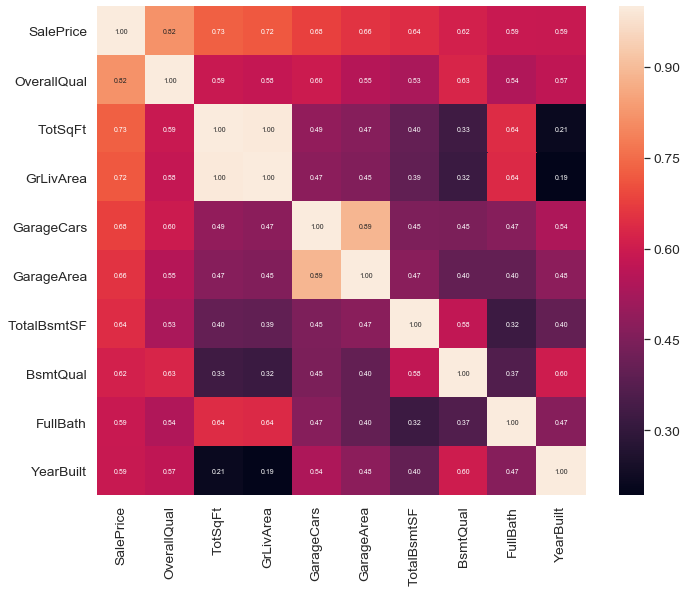

In [33]:
#Filter out 10 highest correlated categories
corr_num = 10
corr_cols = corr_matrix.nlargest(corr_num,'SalePrice')['SalePrice'].index
corr_mat_sales = np.corrcoef(df_train2[corr_cols].values.T)
sns.set(font_scale=1.25)
fig,ax = plt.subplots(figsize=(12,9))
hm = sns.heatmap(corr_mat_sales, cbar=True,annot=True,square=True,fmt='.2f',annot_kws={'size':7}, yticklabels=corr_cols.values, xticklabels=corr_cols.values)

For our analysis, we will use 'OverallQual', 'TotSqFt', 'GrLivArea', 'GarageCars', 'GarageArea', 'BsmtQual', 'FullBath', 'YearBuilt', 'YearRemodAdd' as the variables to expain 'SalePrice' as these have the highest correlations with our dependent variable.

Because we will be using this dataframe going forward, we will save it to a csv and then import it into future notebooks.

In [45]:
df_train2.to_csv('df_train2.csv', sep='\t')